In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq


import cirq
import sympy
import numpy as np
from numpy import linalg as LA
import copy
import itertools
import collections
import json


# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## Definition of two qbits

In [2]:
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])

    
def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit


def two_qubit_pool(source_qubit, sink_qubit, symbols):
    """Make a Cirq circuit to do a parameterized 'pooling' operation, which
    attempts to reduce entanglement down from two qubits to just one."""
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

## QCNN

In [3]:
def quantum_conv_circuit(bits, symbols):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit


def quantum_pool_circuit(source_bits, sink_bits, symbols):
    """A layer that specifies a quantum pooling operation.
    A Quantum pool tries to learn to pool the relevant information from two
    qubits onto 1.
    """
    circuit = cirq.Circuit()
    for source, sink in zip(source_bits, sink_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit

## QFCC

In [4]:
def circuit_11(symbols, qubits):
    circuit = cirq.Circuit()
    # 9 qbits
    circuit += cirq.ry(symbols[0]).on(qubits[0])
    circuit += cirq.ry(symbols[1]).on(qubits[1])
    circuit += cirq.ry(symbols[2]).on(qubits[2])

    circuit += cirq.rz(symbols[3]).on(qubits[0])
    circuit += cirq.rz(symbols[4]).on(qubits[1])
    circuit += cirq.rz(symbols[5]).on(qubits[2])

    circuit += cirq.CNOT(qubits[1], qubits[0])
    circuit += cirq.CNOT(qubits[2], qubits[1])
    
    circuit += cirq.ry(symbols[6]).on(qubits[1])
    circuit += cirq.ry(symbols[7]).on(qubits[2])
    
    circuit += cirq.rz(symbols[8]).on(qubits[1])
    circuit += cirq.rz(symbols[9]).on(qubits[2])
    
    circuit += cirq.CNOT(qubits[2], qubits[1])
    
    return circuit

## Create the model

In [6]:
def create_model_circuit(qubits):
    """Create sequence of alternating convolution and pooling operators 
    which gradually shrink over time."""
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:46')
    # Cirq uses sympy.Symbols to map learnable variables. TensorFlow Quantum
    # scans incoming circuits and replaces these with TensorFlow variables.
    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[:3], qubits[3:],
                                          symbols[15:21])
    model_circuit += quantum_conv_circuit(qubits[3:], symbols[21:36])

    model_circuit += circuit_11(symbols[36:46], qubits[3:])
    
    #model_circuit += (cirq.r(symbols[36]) * cirq.Y(symbols[36])).controlled_by(qubits[5])
    
    #cirq.ControlledGate(cirq.rx(symbols[36]) * cirq.ry(symbols[37]) * cirq.rz(symbols[38])).on(qubits[4], qubits[5])
    #model_circuit += cirq.ControlledGate(my_U).on(qubits[4], qubits[5])
    #model_circuit += cirq.Circuit(custom_gate.on(*qubits[2:4]))
    #model_circuit += quantum_fc_circuit(qubits[3:], symbols[36:75])

    
    return model_circuit


from tensorflow_quantum import differentiators


qubits = cirq.GridQubit.rect(1, 6) #grid of qubit 
readout_operators = cirq.Z(qubits[-1]) #grid of operator i want to average on (final expected value)

# Build a sequential model enacting the logic in 1.3 of this notebook.
inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string) #still general input

#define the differentiator
#differentiator = differentiators.ParameterShift()


#define the model 
quantum_model = tfq.layers.PQC(create_model_circuit(qubits),readout_operators)(inputs)

qcnn_model = tf.keras.Model(inputs=[inputs], outputs=[quantum_model])

# Show the keras plot of the model
tf.keras.utils.plot_model(qcnn_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


## Load data of amplitude encoding

In [7]:
import json

# Open the file in read mode
with open('amplitude_encoding_train.json', 'r') as f:
    # Use json.load() to read the contents of the file
    new_circuit = json.load(f)

# Close the file
f.close()
train_circuits_data = [cirq.read_json(json_text=new_circuit[i]) for i in range((5000))]

# Open the file in read mode
with open('amplitude_encoding_test.json', 'r') as f:
    # Use json.load() to read the contents of the file
    new_circuit = json.load(f)

# Close the file
f.close()
test_circuits_data = [cirq.read_json(json_text=new_circuit[i]) for i in range((500))]

y_train = np.loadtxt("y_train.txt")
y_test = np.loadtxt("y_test.txt")

y_train = y_train[:5000]
y_test = y_test[:500]


In [8]:
# convert to tensors
train_circuits_data = tfq.convert_to_tensor(train_circuits_data)
test_circuits_data = tfq.convert_to_tensor(test_circuits_data)

In [11]:

# Custom accuracy metric.
@tf.function
def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))


qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss=tf.losses.mse,
                   metrics=[custom_accuracy])

In [12]:
history = qcnn_model.fit(x=train_circuits_data,
                         y=y_train,
                         batch_size=75,
                         epochs=50,
                         verbose=1,
                         validation_data=(test_circuits_data, y_test))

Epoch 1/50
67/67 [==============================] - 41s 603ms/step - loss: 0.9292 - custom_accuracy: 0.6287 - val_loss: 0.8870 - val_custom_accuracy: 0.7095
Epoch 2/50
67/67 [==============================] - 39s 578ms/step - loss: 0.7963 - custom_accuracy: 0.8062 - val_loss: 0.8000 - val_custom_accuracy: 0.8181
Epoch 3/50
67/67 [==============================] - 39s 589ms/step - loss: 0.7196 - custom_accuracy: 0.8553 - val_loss: 0.7303 - val_custom_accuracy: 0.8314
Epoch 4/50
67/67 [==============================] - 40s 591ms/step - loss: 0.6310 - custom_accuracy: 0.8928 - val_loss: 0.6471 - val_custom_accuracy: 0.8667
Epoch 5/50
67/67 [==============================] - 38s 570ms/step - loss: 0.5617 - custom_accuracy: 0.9217 - val_loss: 0.5940 - val_custom_accuracy: 0.8867
Epoch 6/50
67/67 [==============================] - 38s 572ms/step - loss: 0.5339 - custom_accuracy: 0.9257 - val_loss: 0.5797 - val_custom_accuracy: 0.9000
Epoch 7/50
67/67 [==============================] - 38s 57

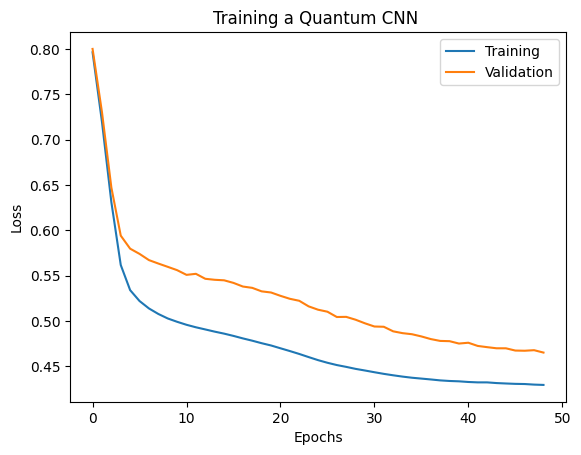

In [14]:
plt.plot(history.history['loss'][1:], label='Training')
plt.plot(history.history['val_loss'][1:], label='Validation')
plt.title('Training a Quantum CNN ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

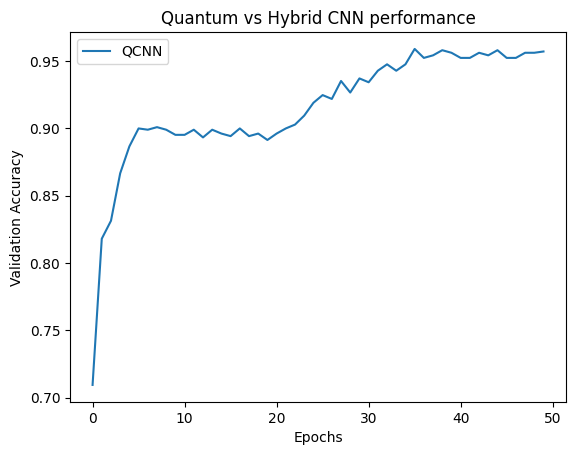

In [13]:
plt.plot(history.history['val_custom_accuracy'], label='QCNN')
plt.title('Quantum vs Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Validation Accuracy')
plt.show()

In [15]:
np.savetxt('11loss.txt', history.history['loss'][1:])
np.savetxt('11val_loss.txt', history.history['val_loss'][1:])

np.savetxt('11val_acc.txt', history.history['val_custom_accuracy'])